### Sensitivity analysis --> Sobol 
Defining parameters to vary and find variance on parameters outcome --> damage important to all actors
Finding variance that explains that damage is highest in other scenarios --> RfR & damage is low --> dike heightening 

In [1]:
## Importing all functions

%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome,
                           perform_experiments, ema_logging,Policy)

from ema_workbench import Samplers

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

from ema_workbench.analysis.scenario_discovery_util import RuleInductionType

from ema_workbench.util import ema_logging

from dike_model_function import DikeNetwork

# exp, out = evaluator.perform_experiments(...,uncertainty_sampling=Samplers.SOBOL)

from SALib.analyze import sobol


In [2]:
from ema_workbench import (
    Model,
    RealParameter,
    IntegerParameter,
    CategoricalParameter,
    ScalarOutcome,
    Samplers,
    perform_experiments,
    MPIEvaluator
)
from ema_workbench.em_framework import Samplers
from ema_workbench.em_framework.salib_samplers import (get_SALib_problem)
from dike_model_function import DikeNetwork
from ema_workbench.util import ema_logging
from SALib.analyze import sobol

# Define the sum_over function
def sum_over(*args):
    numbers = []
    for entry in args:
        try:
            value = sum(entry)
        except TypeError:
            value = entry
        numbers.append(value)
    return sum(numbers)

# Configure logging
ema_logging.log_to_stderr(ema_logging.INFO)

# Define the function to get the model for the given problem formulation
def get_model_for_problem_formulation(problem_formulation_id):
    function = DikeNetwork()
    dike_model = Model("dikesnet", function=function)

    Real_uncert = {"Bmax": [30, 350], "pfail": [0, 1]}  # m and [.]
    cat_uncert_loc = {"Brate": (1.0, 1.5, 10)}
    cat_uncert = {f"discount rate {n}": (1.5, 2.5, 3.5, 4.5) for n in function.planning_steps}
    Int_uncert = {"A.0_ID flood wave shape": [0, 132]}

    uncertainties = []

    for uncert_name in cat_uncert.keys():
        categories = cat_uncert[uncert_name]
        uncertainties.append(CategoricalParameter(uncert_name, categories))

    for uncert_name in Int_uncert.keys():
        uncertainties.append(IntegerParameter(uncert_name, Int_uncert[uncert_name][0], Int_uncert[uncert_name][1]))

    dike_height_levers = []
    for dike in function.dikelist:
        for uncert_name in Real_uncert.keys():
            name = f"{dike}_{uncert_name}"
            lower, upper = Real_uncert[uncert_name]
            uncertainties.append(RealParameter(name, lower, upper))

        for uncert_name in cat_uncert_loc.keys():
            name = f"{dike}_{uncert_name}"
            categories = cat_uncert_loc[uncert_name]
            uncertainties.append(CategoricalParameter(name, categories))
        
        for n in function.planning_steps:
            name = f"{dike}_DikeIncrease {n}"
            dike_height_levers.append(IntegerParameter(name, 0, 10))
        
    dike_model.uncertainties = uncertainties

    dike_height_levers.append(IntegerParameter("EWS_DaysToThreat", 0, 4))  # days
    # Set levers: No RfR, dike heightening
    dike_model.levers = dike_height_levers

    # Define the outcomes
    outcomes = [
        ScalarOutcome('Total Costs', kind=ScalarOutcome.MINIMIZE, function=sum_over, variable_name=[
            f"{dike}_Expected Annual Damage" for dike in function.dikelist] +
            [f"{dike}_Dike Investment Costs" for dike in function.dikelist] +
            ["RfR Total Costs"] 
        ),
        ScalarOutcome('Expected Number of Deaths', kind=ScalarOutcome.MINIMIZE, function=sum_over, variable_name=[
            f"{dike}_Expected Number of Deaths" for dike in function.dikelist]
        ),
        ScalarOutcome('Expected Annual Damage', kind=ScalarOutcome.MINIMIZE, function=sum_over, variable_name=[
            f"{dike}_Expected Annual Damage" for dike in function.dikelist]),
        ScalarOutcome('Dike Investment Costs', kind=ScalarOutcome.MINIMIZE, function=sum_over, variable_name=[f"{dike}_Dike Investment Costs" for dike in function.dikelist]),
        ScalarOutcome('RfR Total Costs', kind=ScalarOutcome.MINIMIZE, function=sum_over, variable_name=["RfR Total Costs"] )
    ]
    
    # 
    # # Define the levers
    # levers = [
    #     # Range of dike heightening:
    #     IntegerParameter("DikeIncrease", 0, 10),  # dm
    # 
    #     # Series of five Room for the River projects:
    #     *[CategoricalParameter(f"{project_id}_RfR", [0, 1]) for project_id in range(0, 5)],
    # 
    #     # Time of warning: 0, 1, 2, 3, 4 days ahead from the flood
    #     IntegerParameter("EWS_DaysToThreat", 0, 4)  # days
    # ]

    # Assign uncertainties, outcomes, and levers to the model
    # dike_model.uncertainties = uncertainties
    dike_model.outcomes = outcomes
    
    # dike_model.levers = levers 

    return dike_model

# Get the model for a specific problem formulation
problem_formulation_id = 6  # Change this to the desired problem formulation
dike_model = get_model_for_problem_formulation(problem_formulation_id)

# Define policies to test different dike height increases
policies = [Policy(f"DikeIncrease_{i}", **{f"{dike}_DikeIncrease {n}": i for dike in dike_model.function.dikelist for n in dike_model.function.planning_steps}, **{"EWS_DaysToThreat": 2}) for i in range(1, 11, 2)]



# Get the model for a specific problem formulation
problem_formulation_id = 6  # Change this to the desired problem formulation
dike_model = get_model_for_problem_formulation(problem_formulation_id)

# Get SALib problem
problem = get_SALib_problem(dike_model.uncertainties)

# Print the problem definition
print(problem)


{'num_vars': 19, 'names': ['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail', 'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate', 'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax', 'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1', 'discount rate 2'], 'bounds': [(0, 133), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (0, 4), (0, 4), (0, 4)]}


In [38]:
n_exp = 750

experiments_sobol, outcomes_sobol = perform_experiments(dike_model, scenarios=n_exp,
                                                        policies=policies,
                                                        uncertainty_sampling=Samplers.SOBOL)

dike_final_sobol = outcomes_sobol["Total Costs"][:,0,-1]
dike_mean_sobol = np.mean(outcomes_sobol["Total Costs"][:,0,:],axis=1)
dike_std_sobol = np.std(outcomes_sobol["Total Costs"][:,0,:],axis=1)

Si = sobol.analyze(problem, dike_mean_sobol, calc_second_order=True, print_to_console=True)


C:\Users\Joost\PycharmProjects\venv\lib\site-packages\scipy\stats\_qmc.py:804: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
[MainProcess/INFO] performing 30000 scenarios * 5 policies * 1 model(s) = 150000 experiments
100%|███████████████████████████████| 150000/150000 [14:57:15<00:00,  2.79it/s]
[MainProcess/INFO] experiments finished


IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

In [3]:
import pandas as pd
import numpy as np
# experiments_sobol.to_csv('experiments_sobol.csv')
# outcomes_df = pd.DataFrame(outcomes_sobol)
# outcomes_df.to_csv('outcomes_sobol.csv', index=False)

# Load the saved DataFrames
experiments_sobol = pd.read_csv('experiments_sobol1.csv')
outcomes_sobol_df = pd.read_csv('outcomes_sobol1.csv')

# Convert outcomes_sobol_df back into a dictionary of numpy arrays
outcomes_sobol = {}
for column in outcomes_sobol_df.columns:
    outcomes_sobol[column] = outcomes_sobol_df[column].to_numpy()

print(outcomes_sobol.keys())

dict_keys(['Total Costs', 'Expected Number of Deaths', 'Expected Annual Damage', 'Dike Investment Costs', 'RfR Total Costs'])


In [4]:
np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

dike_final_sobol = outcomes_sobol["Total Costs"]
dike_mean_sobol = np.mean(outcomes_sobol["Total Costs"])
dike_std_sobol = np.std(outcomes_sobol["Total Costs"])

# Check the shape of the data
print(f"Shape of outcomes_sobol['Total Costs']: {outcomes_sobol['Total Costs'].shape}")

# Ensure we use the correct number of samples
N = outcomes_sobol['Total Costs'].shape[0]

# Sobol analysis
try:
    Si = sobol.analyze(problem, outcomes_sobol['Total Costs'], calc_second_order=True, print_to_console=True)
    print("Sobol analysis completed successfully")
except Exception as e:
    print(f"Error during Sobol analysis: {e}")


Shape of outcomes_sobol['Total Costs']: (150000,)
                               ST   ST_conf
A.0_ID flood wave shape  0.002824  0.000524
A.1_Bmax                 0.001952  0.001292
A.1_Brate                0.000040  0.000054
A.1_pfail                0.562362  0.058750
A.2_Bmax                 0.000129  0.000164
A.2_Brate                0.000011  0.000015
A.2_pfail                0.016374  0.003596
A.3_Bmax                 0.000397  0.000511
A.3_Brate                0.000010  0.000014
A.3_pfail                0.174821  0.025119
A.4_Bmax                 0.000003  0.000004
A.4_Brate                0.000001  0.000001
A.4_pfail                0.001116  0.000330
A.5_Bmax                 0.000000  0.000000
A.5_Brate                0.000000  0.000000
A.5_pfail                0.020871  0.004842
discount rate 0          0.022702  0.002818
discount rate 1          0.009681  0.002000
discount rate 2          0.004811  0.001017
                               S1   S1_conf
A.0_ID flood wave shape -0

In [12]:
Si_first_order = pd.DataFrame({
    'Parameter': problem['names'],
    'S1': Si['S1'],
    'S1_conf': Si['S1_conf']
})

Si_total_order = pd.DataFrame({
    'Parameter': problem['names'],
    'ST': Si['ST'],
    'ST_conf': Si['ST_conf']
})

# Extract second-order indices
second_order_indices = []
for i, name1 in enumerate(problem['names']):
    for j, name2 in enumerate(problem['names']):
        if i < j:
            second_order_indices.append({
                'Parameter 1': name1,
                'Parameter 2': name2,
                'S2': Si['S2'][i, j],
                'S2_conf': Si['S2_conf'][i, j]
            })

Si_second_order = pd.DataFrame(second_order_indices)

# Save the Sobol indices to CSV files
Si_first_order.to_csv('sobol_first_order_indices.csv', index=False)
Si_total_order.to_csv('sobol_total_order_indices.csv', index=False)
Si_second_order.to_csv('sobol_second_order_indices.csv', index=False)

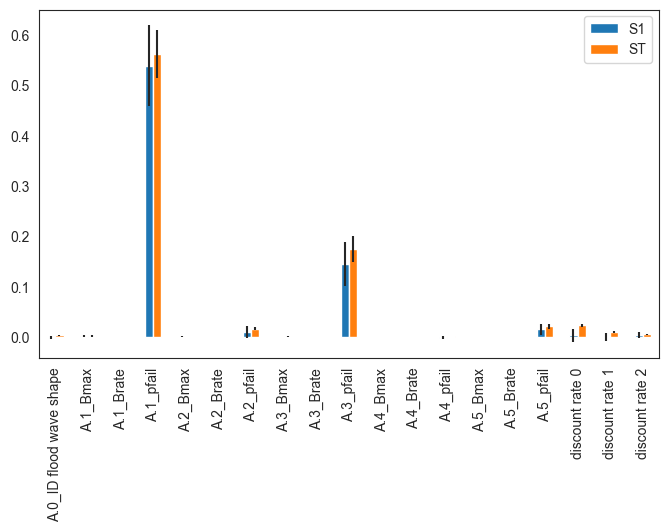

In [5]:
Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from SALib.analyze import sobol

# Check the shape of the data
print(f"Shape of outcomes_sobol['Total Costs']: {outcomes_sobol['Total Costs'].shape}")

# Perform Sobol analysis
n_exp = outcomes_sobol['Total Costs'].shape[0]

# DataFrame to store Sobol indices
s_data = pd.DataFrame(index=problem['names'], columns=np.arange(20, n_exp, 50) * (2 * problem['num_vars'] + 2))

try:
    # Using tqdm to show progress
    for j in tqdm(s_data.columns, desc="Sobol Analysis Progress"):
        # Ensure Y is properly indexed
        scores = sobol.analyze(problem, outcomes_sobol['Total Costs'][0:j], calc_second_order=True, print_to_console=False)
        s_data.loc[:, j] = scores['ST']
    print("Sobol analysis completed successfully")
except IndexError as e:
    print(f"IndexError during Sobol analysis: {e}")
except Exception as e:
    print(f"Error during Sobol analysis: {e}")

# Print the resulting DataFrame
print(s_data)


Shape of outcomes_sobol['Total Costs']: (150000,)


Sobol Analysis Progress:  11%|█▏        | 338/3000 [43:21<7:16:11,  9.83s/it]

In [ ]:
fig, ax = plt.subplots(1)

s_data.T.plot(ax=ax)
ax.set_xlabel('Samples')
ax.set_ylabel('Total index (ST)')
plt.show()

##Extra Trees##

In [3]:
from ema_workbench.analysis import feature_scoring

In [6]:
dike_final_sobol = outcomes_sobol["Total Costs"]
dike_mean_sobol = np.mean(outcomes_sobol["Total Costs"])
dike_std_sobol = np.std(outcomes_sobol["Total Costs"])

In [7]:
res = feature_scoring.get_ex_feature_scores(experiments_sobol, dike_final_sobol,
                                      max_features=0.6, mode=RuleInductionType.REGRESSION)[0]
res

C:\Users\anna\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


,1
0,
A.1_pfail,0.436930
A.3_pfail,0.146452
policy,0.033233
A.5_DikeIncrease 2,0.025881
A.2_DikeIncrease 0,0.023921
A.4_DikeIncrease 0,0.023678
A.2_DikeIncrease 1,0.021366
A.1_DikeIncrease 2,0.019767
A.3_DikeIncrease 0,0.019131


C:\Users\anna\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
C:\Users\anna\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


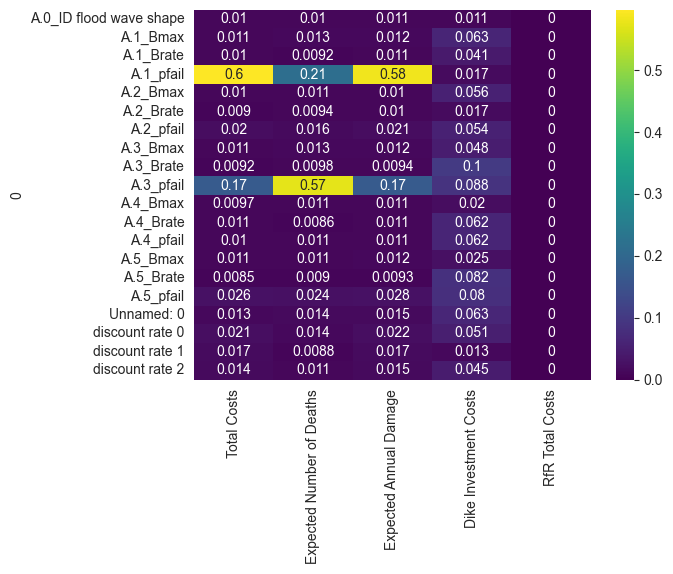

C:\Users\anna\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
C:\Users\anna\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


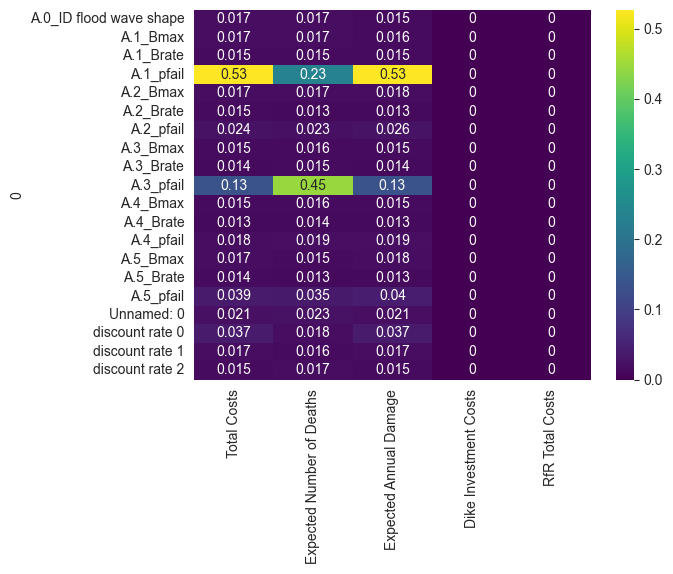

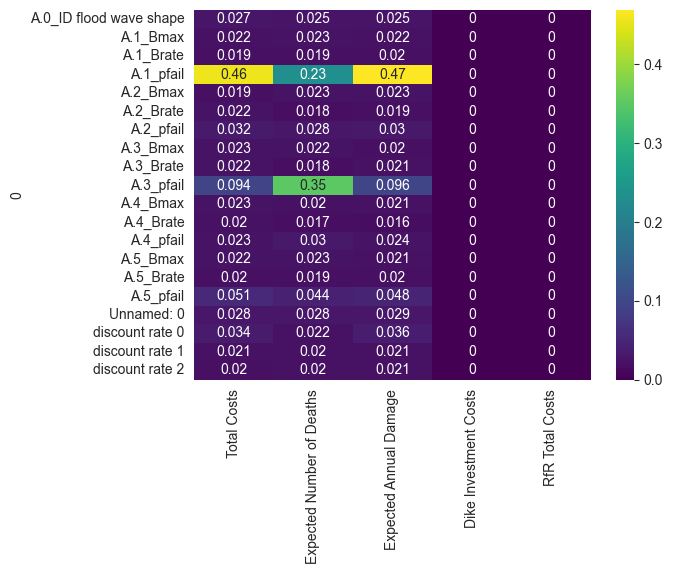

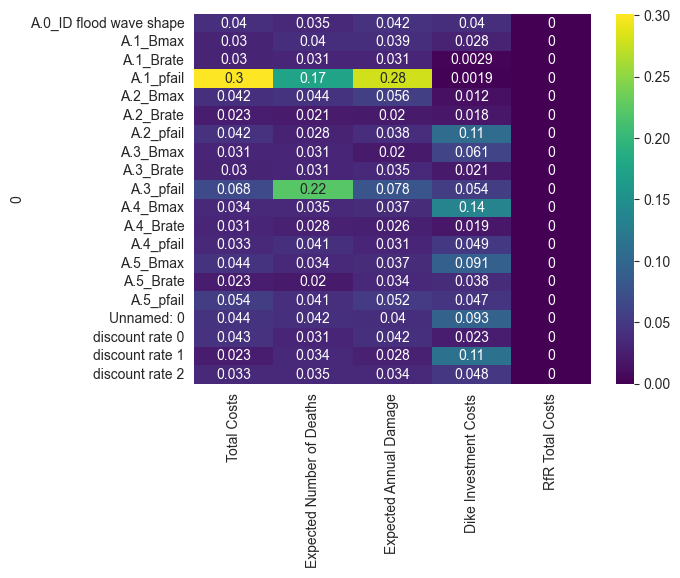

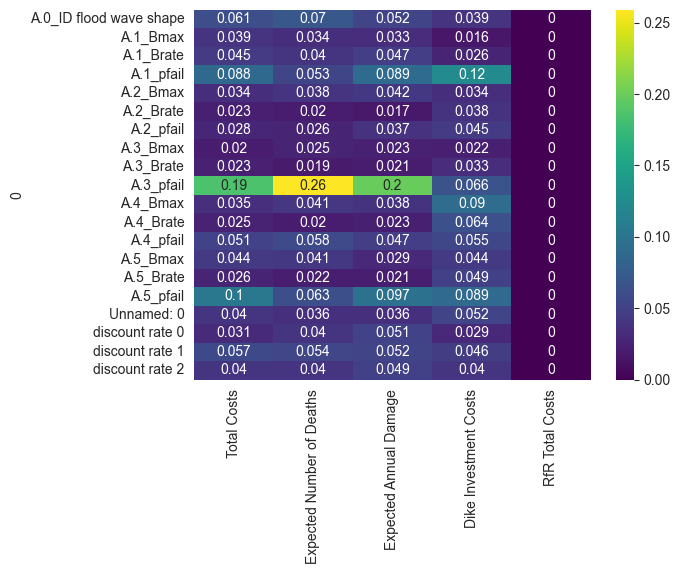

In [11]:
import seaborn as sns
cleaned_experiments = experiments_sobol.drop(columns=[l.name for l in dike_model.levers])

for policy in experiments_sobol.policy.unique():
    logical = experiments_sobol.policy == policy
    subset_results = {k:v[logical] for k,v in outcomes_sobol.items()}
    scores = feature_scoring.get_feature_scores_all(cleaned_experiments[logical],
                                                   subset_results)
    sns.heatmap(scores, annot=True, cmap='viridis')
    plt.show()

C:\Users\anna\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
C:\Users\anna\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


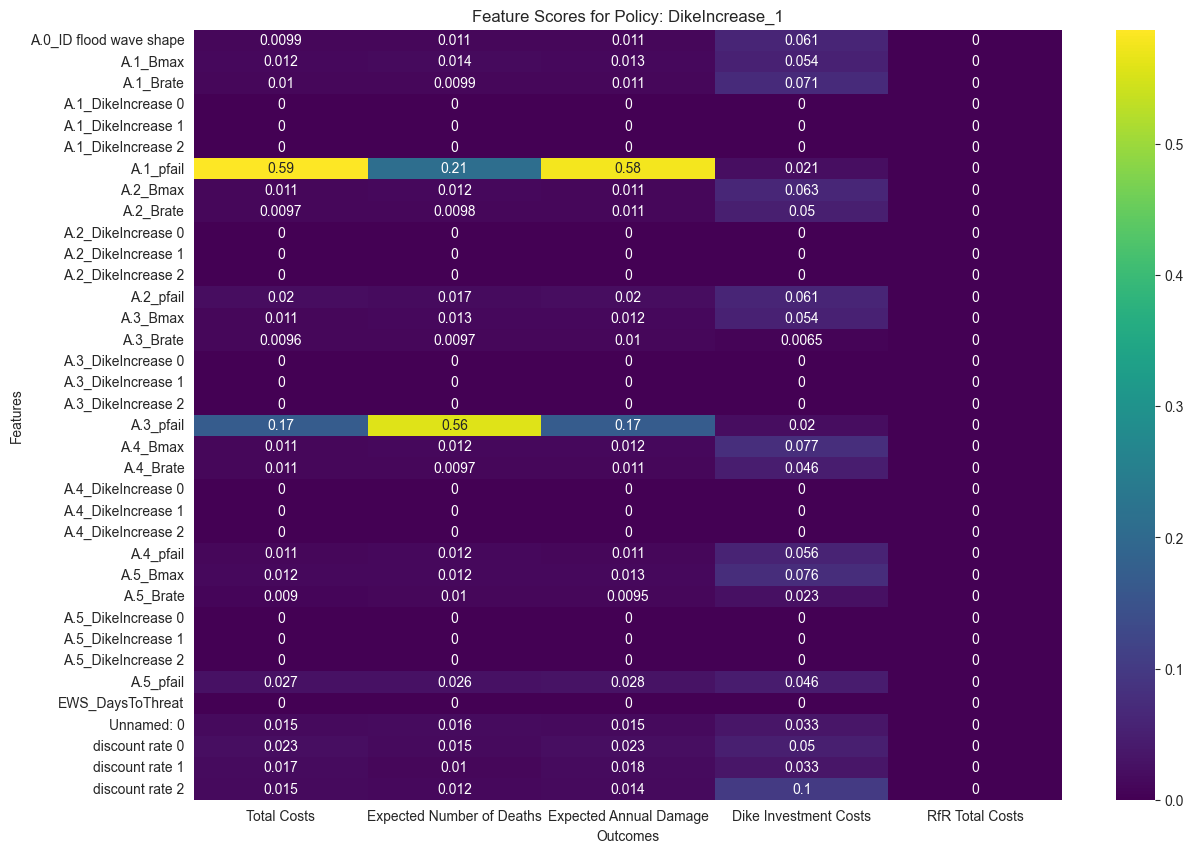

C:\Users\anna\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
C:\Users\anna\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


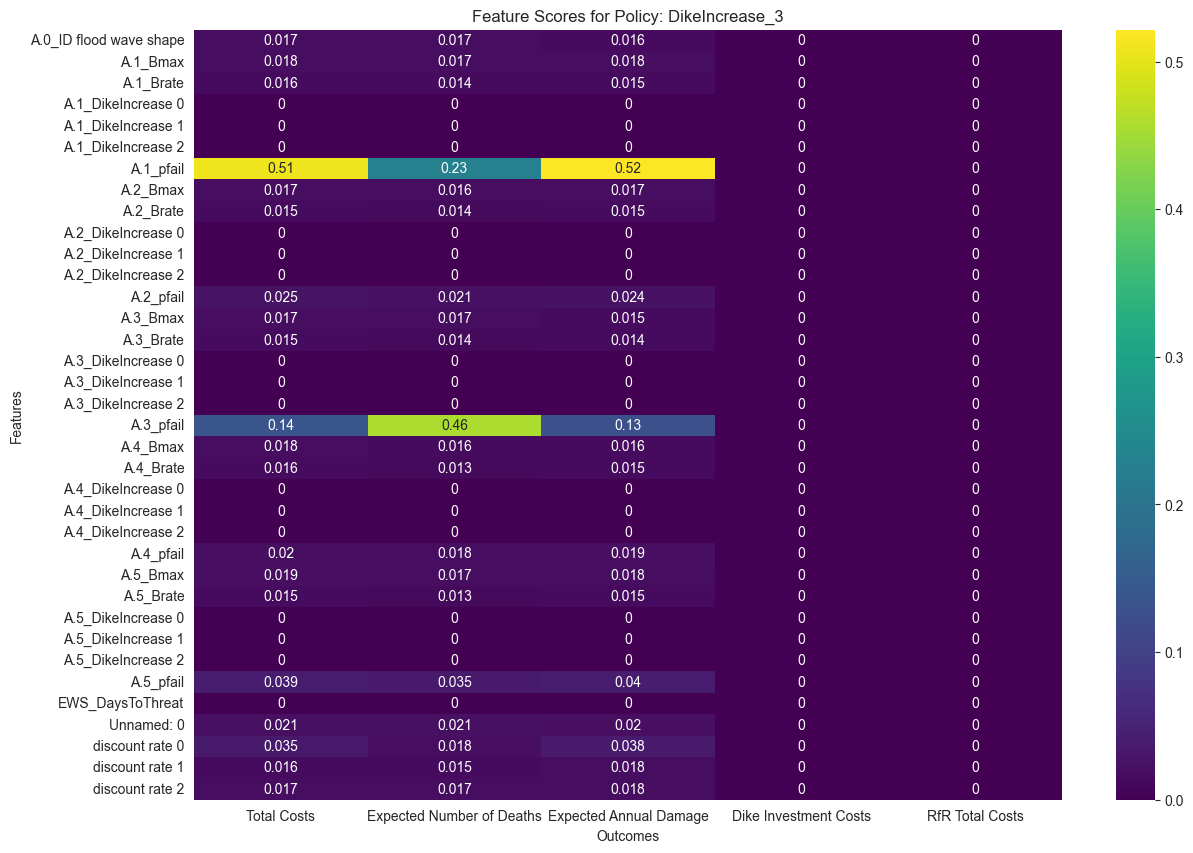

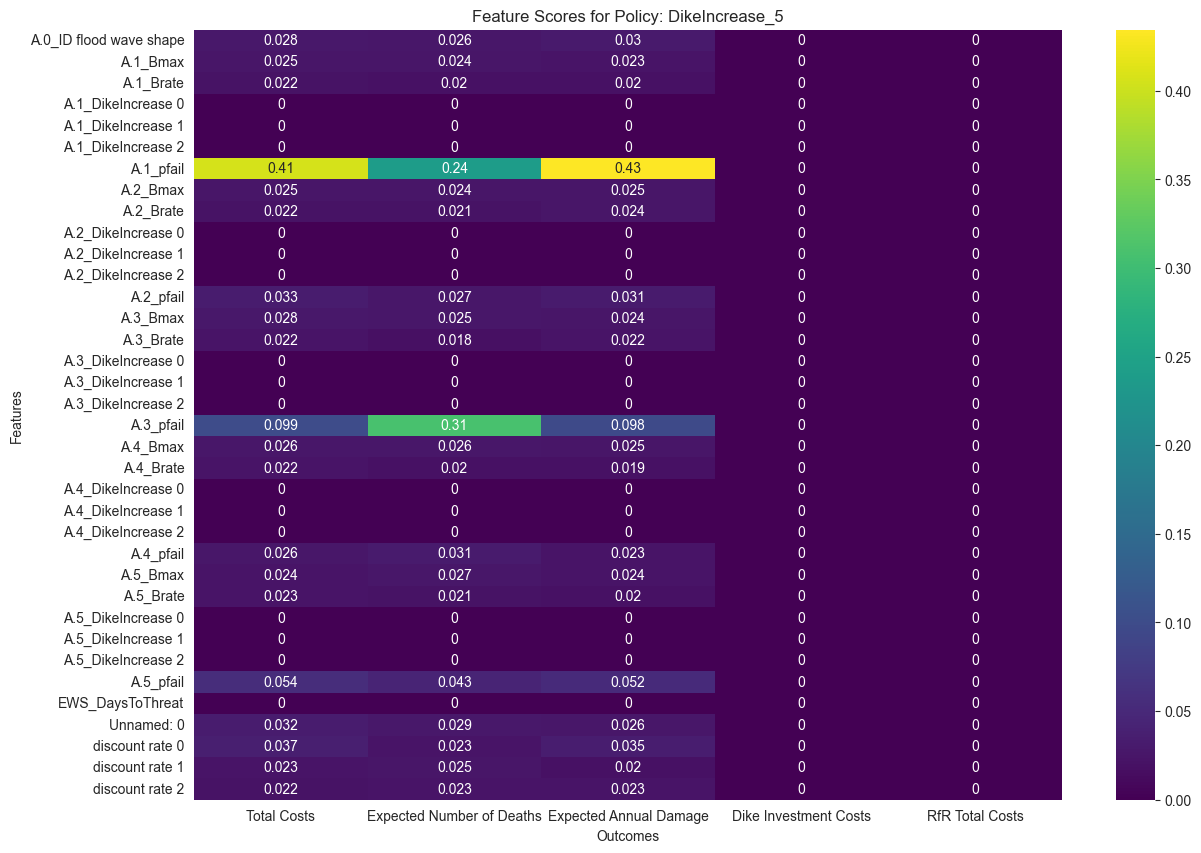

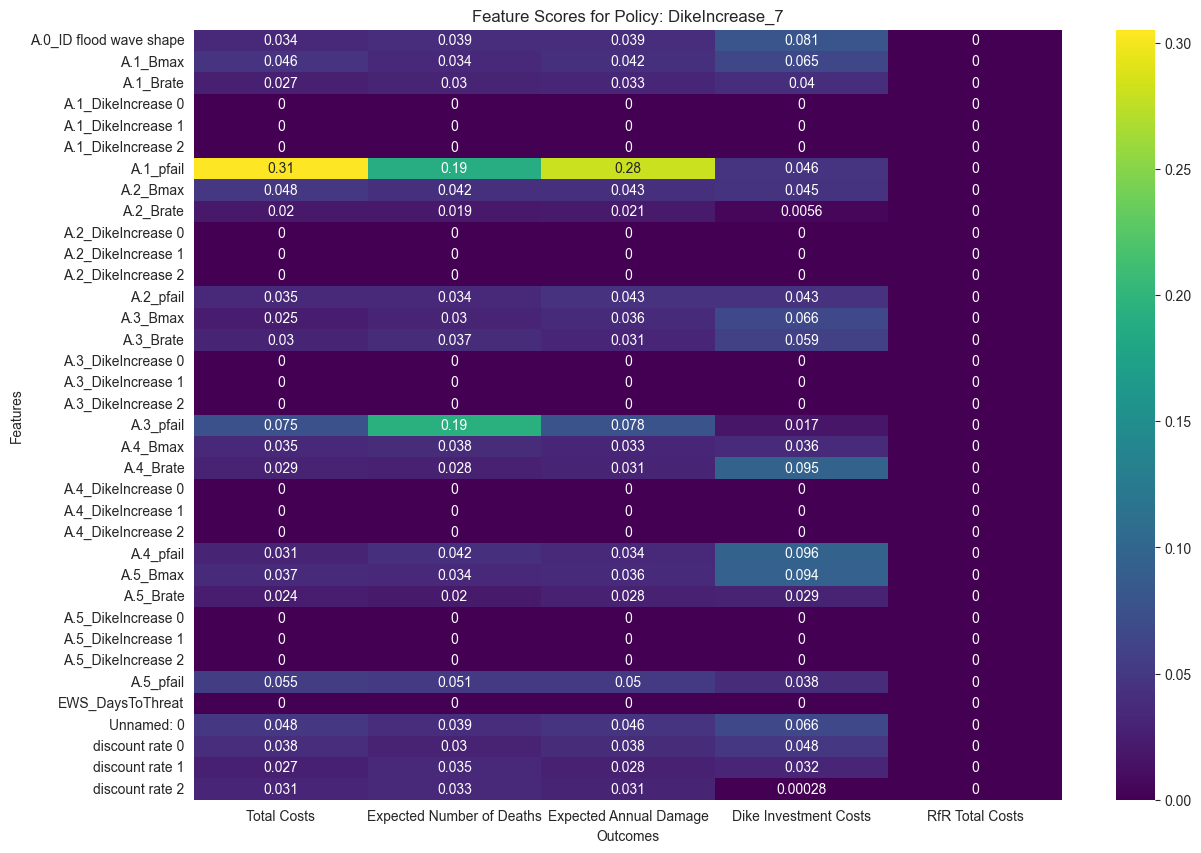

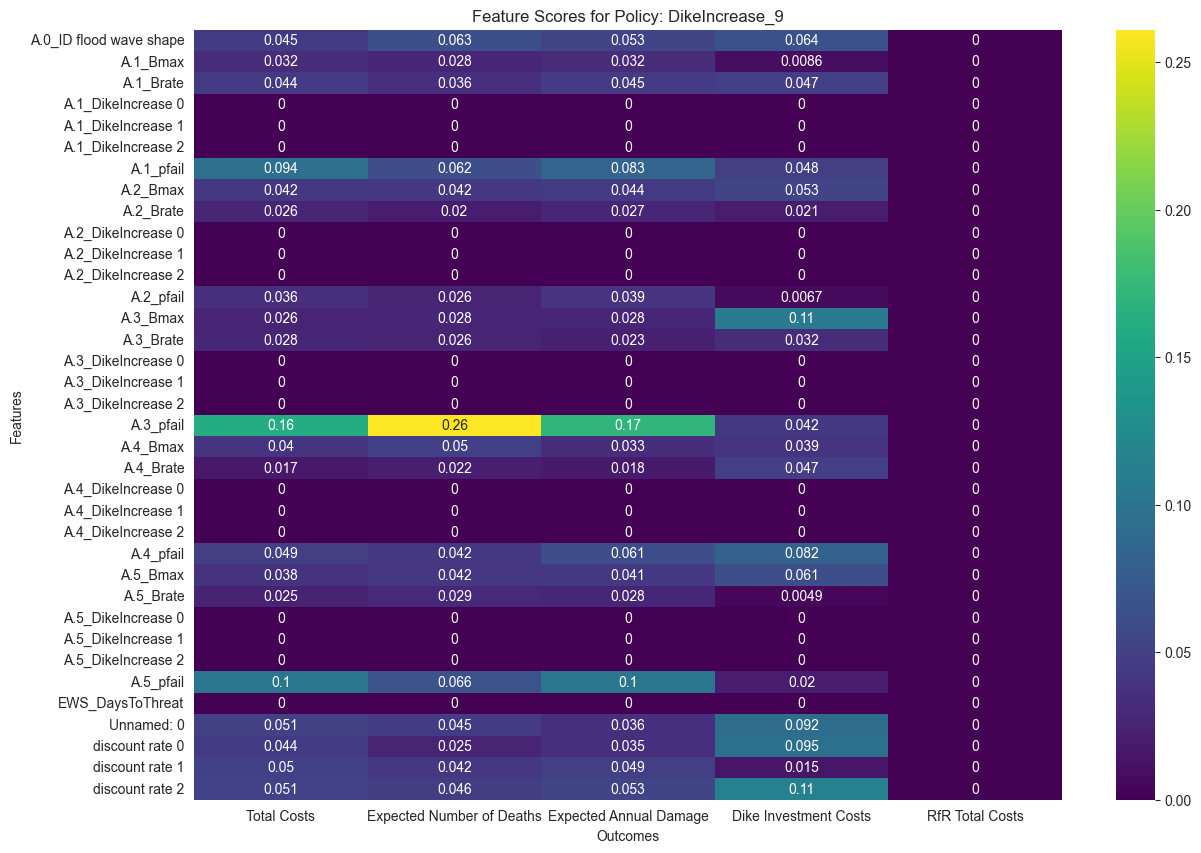

AxisError: axis 1 is out of bounds for array of dimension 1

In [15]:
for policy in experiments_sobol.policy.unique():
    logical = experiments_sobol.policy == policy
    subset_results = {k: v[logical] for k, v in outcomes_sobol.items()}
    scores = feature_scoring.get_feature_scores_all(experiments_sobol[logical], subset_results)
    plt.figure(figsize=(14, 10))
    sns.heatmap(scores, annot=True, cmap='viridis')
    plt.title(f'Feature Scores for Policy: {policy}')
    plt.xlabel('Outcomes')
    plt.ylabel('Features')
    plt.show()

# Combined feature scoring for increasing sample sizes
combined_scores = []
dike_mean_sobol = outcomes_sobol['Total Costs'].mean(axis=1)

for j in range(100, experiments_sobol.shape[0], 100):
    scores = feature_scoring.get_ex_feature_scores(experiments_sobol.iloc[0:j, :],
                                                   dike_mean_sobol[0:j],
                                                   max_features=0.6,
                                                   mode=feature_scoring.RuleInductionType.REGRESSION)[0]
    scores.columns = [j]
    combined_scores.append(scores)

combined_scores = pd.concat(combined_scores, axis=1, sort=True)

fig, ax = plt.subplots(figsize=(14, 10))
combined_scores.T.plot(ax=ax)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlabel('Samples')
ax.set_ylabel('Feature Scores')
plt.title('Combined Feature Scores Over Samples')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.feature_scoring import RuleInductionType
from tqdm import tqdm  # Import tqdm for the progress bar

# Assuming outcomes_sobol and experiments_sobol are loaded correctly as previously mentioned

# Ensure dike_mean_sobol is correctly calculated as an array
dike_mean_sobol = np.mean(outcomes_sobol["Total Costs"].reshape(-1, 1), axis=1)

combined_scores = []

# Adding a progress bar to the loop
for j in tqdm(range(100, experiments_sobol.shape[0], 100), desc="Feature Scoring Progress"):
    scores = feature_scoring.get_ex_feature_scores(experiments_sobol.iloc[0:j, :],
                                                   dike_mean_sobol[0:j],
                                                   max_features=0.6,
                                                   mode=RuleInductionType.REGRESSION)[0]
    scores.columns = [j]
    combined_scores.append(scores)

# Combine the scores DataFrames
combined_scores_df = pd.concat(combined_scores, axis=1)

# Optionally, print or save the combined_scores_df
print(combined_scores_df)


Feature Scoring Progress:   0%|          | 0/1499 [00:00<?, ?it/s]C:\Users\Joost\PycharmProjects\venv\lib\site-packages\sklearn\utils\_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
Feature Scoring Progress:   0%|          | 1/1499 [00:00<04:17,  5.82it/s]C:\Users\Joost\PycharmProjects\venv\lib\site-packages\sklearn\utils\_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
Feature Scoring Progress:   0%|          | 2/1499 [00:00<04:03,  6.15it/s]C:\Users\Joost\PycharmProjects\venv\lib\site-packages\sklearn\utils\_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
Feature Scoring Progress:   0%|          | 3/1499 [00:00<04:41,  5.31it/s]C:\Users\Joost\PycharmProjects\venv\lib\site-packages\sklearn\utils\_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  ret

In [ ]:
fig, ax = plt.subplots(1)

combined_scores.T.plot(ax=ax)
ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel('Samples')
ax.set_ylabel('feature scores')
plt.show()

In [ ]:
cleaned_experiments = experiments.drop(columns=[l.name for l in lake_model.levers])

scores = feature_scoring.get_feature_scores_all(cleaned_experiments,results)

In [ ]:
import seaborn as sns
cleaned_experiments = experiments.drop(columns=[l.name for l in lake_model.levers])

for policy in experiments.policy.unique():
    logical = experiments.policy == policy
    subset_results = {k:v[logical] for k,v in results.items()}
    scores = feature_scoring.get_feature_scores_all(cleaned_experiments[logical],
                                                   subset_results)
    sns.heatmap(scores, annot=True, cmap='viridis')
    plt.show()